## 0. Import Library

In [1]:
import torch.utils.data as utils
import torch.nn.functional as F
import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import numpy as np
import pandas as pd
import math
import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print(torch.__version__)

2.1.2+cu121


## Load Example Dataset

In [4]:
import pandas as pd

# Specify the file path
file_path = 'TruckParkingQuery_20220101_20220601.csv'

# Read data from the text file into a pandas DataFrame
df = pd.read_csv(file_path)  

# Print or use the resulting DataFrame
df

,siteId,timestamp,capacity,lowThreshold,open,reportedAvailable,timeStampStatic,trend,trustdata
0,WI00039IS0011300SRSTARE11,2022-01-01T00:02:09Z,68,13,1,54,2020-07-31T18:57:57Z,FILLING,1
1,WI00039IS0011300SRSTARE11,2022-01-01T00:04:09Z,68,13,1,53,2020-07-31T18:57:57Z,FILLING,1
2,WI00039IS0011300SRSTARE11,2022-01-01T00:09:19Z,68,13,1,54,2020-07-31T18:57:57Z,FILLING,1
3,WI00039IS0011300SRSTARE11,2022-01-01T00:15:59Z,68,13,1,54,2020-07-31T18:57:57Z,STEADY,1
4,WI00039IS0011300SRSTARE11,2022-01-01T00:20:20Z,68,13,1,54,2020-07-31T18:57:57Z,STEADY,1
...,...,...,...,...,...,...,...,...,...
101627,WI00039IS0011300SRSTARE11,2022-06-01T23:51:05Z,68,13,1,38,2020-07-31T18:57:57Z,FILLING,1
101628,WI00039IS0011300SRSTARE11,2022-06-01T23:52:54Z,68,13,1,39,2020-07-31T18:57:57Z,STEADY,1
101629,WI00039IS0011300SRSTARE11,2022-06-01T23:55:52Z,68,13,1,40,2020-07-31T18:57:57Z,STEADY,1
101630,WI00039IS0011300SRSTARE11,2022-06-01T23:57:15Z,68,13,1,39,2020-07-31T18:57:57Z,STEADY,1


In [5]:
df.loc[df.reportedAvailable == 'LOW', 'reportedAvailable'] = 0
df['reportedAvailable'] = df['reportedAvailable'].astype(str).astype(int)

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['am_pm_indicator'] = (df['timestamp'].dt.hour // 12).astype(int)

In [7]:
df

,siteId,timestamp,capacity,lowThreshold,open,reportedAvailable,timeStampStatic,trend,trustdata,am_pm_indicator
0,WI00039IS0011300SRSTARE11,2022-01-01 00:02:09+00:00,68,13,1,54,2020-07-31T18:57:57Z,FILLING,1,0
1,WI00039IS0011300SRSTARE11,2022-01-01 00:04:09+00:00,68,13,1,53,2020-07-31T18:57:57Z,FILLING,1,0
2,WI00039IS0011300SRSTARE11,2022-01-01 00:09:19+00:00,68,13,1,54,2020-07-31T18:57:57Z,FILLING,1,0
3,WI00039IS0011300SRSTARE11,2022-01-01 00:15:59+00:00,68,13,1,54,2020-07-31T18:57:57Z,STEADY,1,0
4,WI00039IS0011300SRSTARE11,2022-01-01 00:20:20+00:00,68,13,1,54,2020-07-31T18:57:57Z,STEADY,1,0
...,...,...,...,...,...,...,...,...,...,...
101627,WI00039IS0011300SRSTARE11,2022-06-01 23:51:05+00:00,68,13,1,38,2020-07-31T18:57:57Z,FILLING,1,1
101628,WI00039IS0011300SRSTARE11,2022-06-01 23:52:54+00:00,68,13,1,39,2020-07-31T18:57:57Z,STEADY,1,1
101629,WI00039IS0011300SRSTARE11,2022-06-01 23:55:52+00:00,68,13,1,40,2020-07-31T18:57:57Z,STEADY,1,1
101630,WI00039IS0011300SRSTARE11,2022-06-01 23:57:15+00:00,68,13,1,39,2020-07-31T18:57:57Z,STEADY,1,1


In [8]:
# filter only segment 114+04179
occ_matrix = df[['reportedAvailable','am_pm_indicator']]
occ_matrix

,reportedAvailable,am_pm_indicator
0,54,0
1,53,0
2,54,0
3,54,0
4,54,0
...,...,...
101627,38,1
101628,39,1
101629,40,1
101630,39,1


## 1. Prepare Dataset

In [9]:
def PrepareDataset(occ_matrix, BATCH_SIZE = 40, seq_len = 10, pred_len = 1, train_propotion = 0.7, valid_propotion = 0.2):
    """ Prepare training and testing datasets and dataloaders.
    
    Convert occupancy matrix to training and testing dataset. 
    The vertical axis of occ_matrix is the time axis and the horizontal axis 
    is the spatial axis.
    
    Args:
        occ_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """
    # number of rows
    time_len = occ_matrix.shape[0]
    
    # Normalization 
    max_occ = occ_matrix.max().max()
    occ_matrix =  occ_matrix / max_occ
    
    # Sequence Generation
    occ_sequences, occ_labels = [], []
    for i in range(time_len - seq_len - pred_len):
        occ_sequences.append(occ_matrix.iloc[i:i+seq_len].values)
        occ_labels.append(occ_matrix.iloc[i+seq_len:i+seq_len+pred_len].values)
    occ_sequences, occ_labels = np.asarray(occ_sequences), np.asarray(occ_labels)
    
    # shuffle and split the dataset to training and testing datasets
    sample_size = occ_sequences.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.shuffle(index)
    
    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))
    
    train_data, train_label = occ_sequences[:train_index], occ_labels[:train_index]
    valid_data, valid_label = occ_sequences[train_index:valid_index], occ_labels[train_index:valid_index]
    test_data, test_label = occ_sequences[valid_index:], occ_labels[valid_index:]
    
    # Conversion to PyTorch Tensors
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)
    
    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)
    
    # Dataloader Creation
    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    
    return train_dataloader, valid_dataloader, test_dataloader, max_occ

In [10]:
train_dataloader, valid_dataloader, test_dataloader, max_occ = PrepareDataset(occ_matrix)

In [11]:
inputs, labels = next(iter(train_dataloader))
[batch_size, step_size, fea_size] = inputs.size()

# fea_size = feature size
input_dim = fea_size
hidden_dim = fea_size
output_dim = fea_size

## 2. Set up train/test model

In [12]:
def TrainModel(model, train_dataloader, valid_dataloader, learning_rate=1e-5, num_epochs=300, patience=10, min_delta=0.00001):
    """Train a PyTorch model using training and validation data
    model = model name
    train_dataloader = dataset for training
    valid_dataloader = dataset for validation
    """
    
    # 1) Data Handling
    # Extracts the dimensions of the input data from the first batch in the training dataset
    [batch_size, step_size, fea_size] = next(iter(train_dataloader))[0].size()
    input_dim = fea_size
    hidden_dim = fea_size
    output_dim = fea_size
    
    # 2) Device Selection
    # Chooses the device (GPU if available, otherwise CPU) for computation
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Moves the model to the chosen device
    model.to(device)
    
    # 3) Loss Functions and Optimizer
    # Defines the Mean Squared Error loss
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.L1Loss()
    
    # Initializes the RMSprop optimizer with specified learning rate
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    # Variables for logging losses and early stopping
    interval = 100
    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []
    
    # Time tracking variables
    cur_time = time.time()
    pre_time = time.time()
    
    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0
    
    
    # 4) Training Loops
    # Performs forward pass, computes the loss, performs backward pass, and updates the model parameters.
    # Iterates over epochs and batches in the training data
    for epoch in range(num_epochs):
        
        trained_number = 0
        
        # Iterator for validation data
        valid_dataloader_iter = iter(valid_dataloader)
        
        losses_epoch_train = []
        losses_epoch_valid = []
        
        # Loop over training data
        for data in train_dataloader:
            inputs, labels = data
            
            # Skip incomplete batches
            if inputs.shape[0] != batch_size:
                continue
            
            # Move data to the chosen device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Set the gradients to zero before starting to do backpropagation
            # Zero the gradients, forward pass, backward pass, optimize
            model.zero_grad()

            outputs = model(inputs)
            
            loss_train = loss_MSE(outputs, torch.squeeze(labels))
            
            losses_train.append(loss_train.item())
            losses_epoch_train.append(loss_train.item())
            
            optimizer.zero_grad()
            
            loss_train.backward()
            
            optimizer.step()
            
            # 5) Validation
            # performed after each training epoch
            # Uses a separate validation dataset (valid_dataloader)
            # Monitors and logs training and validation losses
            try: 
                inputs_val, labels_val = next(valid_dataloader_iter)
            except StopIteration:
                valid_dataloader_iter = iter(valid_dataloader)
                inputs_val, labels_val = next(valid_dataloader_iter)
            
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)

            loss_valid = loss_MSE(outputs_val, torch.squeeze(labels_val))
            losses_valid.append(loss_valid.item())
            losses_epoch_valid.append(loss_valid.item())
            
            # Output
            trained_number += 1
        
        # Calculate average losses for the epoch
        avg_losses_epoch_train = np.mean(losses_epoch_train)
        avg_losses_epoch_valid = np.mean(losses_epoch_valid)
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)
        
        # 6) Early Stopping
        # Implements early stopping based on the validation loss
        # Terminates training if the validation loss doesn't improve for a certain number of consecutive epochs.
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid 
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print('Early Stopped at Epoch:', epoch)
                    break
        
        # Print training parameters
        cur_time = time.time()
        print('Epoch: {}, train_loss: {}, valid_loss: {}, time: {}, best model: {}'.format(
            epoch,
            np.around(avg_losses_epoch_train, decimals=8),
            np.around(avg_losses_epoch_valid, decimals=8),
            np.around([cur_time - pre_time], decimals=2),
            is_best_model))
        pre_time = cur_time
    
    # Return the best model and the collected losses
    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]


In [13]:
def TestModel(model, test_dataloader, max_speed):
    
    inputs, labels = next(iter(test_dataloader))
    [batch_size, step_size, fea_size] = inputs.size()

    cur_time = time.time()
    pre_time = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.MSELoss()
    
    tested_batch = 0
    
    losses_mse = []
    losses_l1 = [] 
    
    for data in test_dataloader:
        inputs, labels = data
        
        if inputs.shape[0] != batch_size:
            continue
    
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else: 
            inputs, labels = Variable(inputs), Variable(labels)

        # rnn.loop() 
        hidden = model.initHidden(batch_size)

        outputs = None
        outputs = model(inputs)
    
    
        loss_MSE = torch.nn.MSELoss()
        loss_L1 = torch.nn.L1Loss()
        loss_mse = loss_MSE(outputs, torch.squeeze(labels))
        loss_l1 = loss_L1(outputs, torch.squeeze(labels))
    
        losses_mse.append(loss_mse.cpu().data.numpy())
        losses_l1.append(loss_l1.cpu().data.numpy())
    
        tested_batch += 1
    
        if tested_batch % 1000 == 0:
            cur_time = time.time()
            print('Tested #: {}, loss_l1: {}, loss_mse: {}, time: {}'.format( \
                  tested_batch * batch_size, \
                  np.around([loss_l1.data[0]], decimals=8), \
                  np.around([loss_mse.data[0]], decimals=8), \
                  np.around([cur_time - pre_time], decimals=8) ) )
            pre_time = cur_time
    losses_l1 = np.array(losses_l1)
    losses_mse = np.array(losses_mse)
    mean_l1 = np.mean(losses_l1) * max_speed
    std_l1 = np.std(losses_l1) * max_speed
    
    print('Tested: L1_mean: {}, L1_std : {}'.format(mean_l1, std_l1))
    return [losses_l1, losses_mse, mean_l1, std_l1]

In [14]:
def TestModel(model, test_dataloader, max_speed):
    """Evaluating a PyTorch model on a test dataset"""
    # 1) Data Handling
    # Attempts to extract the first batch of test data, handling the case where the test dataset is empty
    try:
        inputs, labels = next(iter(test_dataloader))
    except StopIteration:
        return []  
    
    # Extract dimensions of input data from the first batch in the test dataset
    [batch_size, step_size, fea_size] = inputs.size()
    
    # Record the current time for time tracking
    cur_time = time.time()
    pre_time = time.time()
    
    # 2) Device Selection
    # Check if GPU is available
    use_gpu = torch.cuda.is_available()
    
    # 3) Loss Functions
    # Define loss functions (Mean Squared Error loss + the L1 Loss)
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.L1Loss()
    
    # 4) Testing Loop
    # Performs a forward pass through the model and calculates MSE and L1 losses
    # Initialize variables for tracking testing progress
    tested_batch = 0
    losses_mse = []
    losses_l1 = []
    
    ground_truth_values = []
    predictions = []
    
    # Loop over batches in the test dataset
    for data in test_dataloader:
        inputs, labels = data
        
        # Skip incomplete batches
        if inputs.shape[0] != batch_size:
            continue
        
        # Move data to GPU if available
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        ground_truth_values.append(labels.cpu().data.numpy())
            
        # rnn.loop() 
        hidden = model.initHidden(batch_size)
        
        # Forward pass through the model
        outputs = model(inputs)
        
        predictions.append(outputs.cpu().data.numpy())
        
        # Calculate loss values
        loss_mse = loss_MSE(outputs, torch.squeeze(labels))
        loss_l1 = loss_L1(outputs, torch.squeeze(labels))
        
        # Append loss values to lists for later analysis
        losses_mse.append(loss_mse.cpu().data.numpy())
        losses_l1.append(loss_l1.cpu().data.numpy())
        
        tested_batch += 1
        
        # Print testing progress every 1000 batches
        if tested_batch % 1000 == 0:
            cur_time = time.time()
            print('Tested #: {}, loss_l1: {}, loss_mse: {}, time: {}'.format( \
                  tested_batch * batch_size, \
                  np.around([loss_l1.data[0]], decimals=8), \
                  np.around([loss_mse.data[0]], decimals=8), \
                  np.around([cur_time - pre_time], decimals=8) ) )
            pre_time = cur_time
            
    predictions = np.concatenate(predictions, axis=0)        
    ground_truth_values = np.concatenate(ground_truth_values, axis=0)
    
    # Convert lists of losses to NumPy arrays for further analysis
    losses_l1 = np.array(losses_l1)
    losses_mse = np.array(losses_mse)
    
    # Calculate mean and standard deviation of L1 losses
    mean_l1 = np.mean(losses_l1) * max_speed
    std_l1 = np.std(losses_l1) * max_speed
    
    # Print summary statistics
    print('Tested: L1_mean: {}, L1_std : {}'.format(mean_l1, std_l1))
    
    # Return a list containing losses and summary statistics
    return [losses_l1, losses_mse, mean_l1, std_l1, predictions, ground_truth_values]


## 3. Define LSTM model

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, cell_size, hidden_size, output_last = True):
        """
        A simple Long Short-Term Memory (LSTM) module
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        """
        super(LSTM, self).__init__()
        
        # Initialize LSTM parameters
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        # Decide whether to output only the last step's hidden state
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        """LSTM cell operation for a single time step"""
        combined = torch.cat((input, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        if self.output_last:
            """Output only the hidden state of the last time step"""
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
            return Hidden_State
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
        """ Initialize hidden and cell states for the first time step"""
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State

## 4. Train model & Get prediction result

In [16]:
lstm = LSTM(input_dim, hidden_dim, output_dim, output_last = True)
lstm, lstm_loss = TrainModel(lstm, train_dataloader, valid_dataloader, num_epochs = 10)
lstm_test = TestModel(lstm, test_dataloader, max_occ )

Epoch: 0, train_loss: 0.15543571, valid_loss: 0.14754822, time: [37.1], best model: 1
Epoch: 1, train_loss: 0.14146604, valid_loss: 0.13408021, time: [36.88], best model: 1
Epoch: 2, train_loss: 0.1275332, valid_loss: 0.12072958, time: [36.79], best model: 1
Epoch: 3, train_loss: 0.11376594, valid_loss: 0.10757875, time: [36.67], best model: 1
Epoch: 4, train_loss: 0.10030643, valid_loss: 0.09477612, time: [36.75], best model: 1
Epoch: 5, train_loss: 0.08726064, valid_loss: 0.08232162, time: [37.32], best model: 1
Epoch: 6, train_loss: 0.07475707, valid_loss: 0.07041674, time: [36.78], best model: 1
Epoch: 7, train_loss: 0.06305538, valid_loss: 0.05918652, time: [36.49], best model: 1
Epoch: 8, train_loss: 0.05241061, valid_loss: 0.04910408, time: [36.49], best model: 1
Epoch: 9, train_loss: 0.04304856, valid_loss: 0.04022267, time: [36.46], best model: 1
Tested: L1_mean: 9.202300608158112, L1_std : 0.6523410156369209


## 5. Visualize result

In [26]:
dataset = pd.DataFrame({'predict': lstm_test[4][:,0], 'truth': lstm_test[5][:,0][:,0]})

<Axes: >

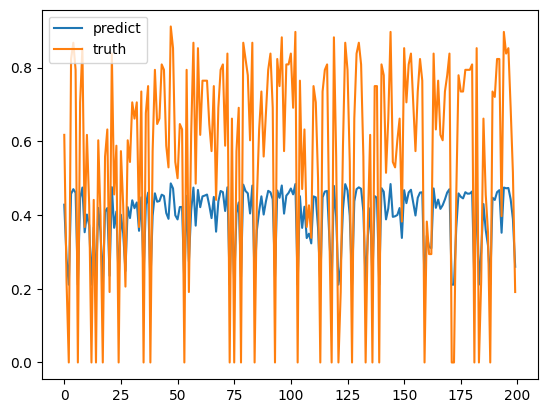

In [41]:
dataset[:200].plot.line()

In [40]:
# mean L1 lose
lstm_test[2]

9.202300608158112